<a href="https://colab.research.google.com/github/tekoryu/rough-on-rats/blob/main/notebooks/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engenharia de Softwares Inteligentes


## Titanic Challenge


Desafio, dados originais e detalhes da base disponiveis em:

https://www.kaggle.com/competitions/titanic

## Descrição


O conjunto de dados é do tipo categórico, onde precisaremos classificar cada um dos registros da lista como sobrevivente ou não ao famoso naufrágio. Com base em uma lista de treinamento contendo sobreviventes já classificados o objetivo é prever com relativa acurácia em relação aos demais. A estratégia que seguiremos é de _feature engineering_ para obter dados relativos a condição economica, social e de gênero dos passageiros, agrupando ao máximo os casos diversos para depois jogar essas informações como colunas com valores booleanos. A partir daí serão utilizadas as técnicas de particionamento, pipeline e hiperparametrização conforme visto no curso.

In [326]:
import re
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score


## Carga do Dataset

Os arquivos do dataset possuem um arquivo de teste, que será ignorado e testado apenas ao final.

In [290]:
# Arquivos do Kaggle
url = "https://raw.githubusercontent.com/tekoryu/rough-on-rats/main/data/titanic/train.csv"
url2 = "https://raw.githubusercontent.com/tekoryu/rough-on-rats/main/data/titanic/test.csv"

# Carga no Pandas
df_treino = pd.read_csv(url, delimiter=',')
df_teste = pd.read_csv(url2, delimiter=',')

# Exibe a primeira linha do dataset
df_treino.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dicionário de Dados

-  Survival = [0,1] Se a pessoa sobreviveu.
-  Pclass = [1,2,3] Primeira, Segunda e Terceira Classe
-  Sex = ["Male", "Female"] Sexo
-  Age = Idade
-  SibSP = Irmãos e Conjuges
-  Parch = Filhos?
-  Ticket = Contem codigos que nao consegui explicar a natureza
-  Fare = Valor do ingresso
-  Cabin = Número da Cabine
-  Embarked = Inicial do porto de embarque

## Etapa I - Tratamento Inicial dos Dados e Feature Engineering

Da observação dos dados temos como premissa que a definição de quem foi salvo se deu por avaliação de atributos (classe econômica, gênero, idade etc).
Vamos buscar reforçar esses atributos a partir dos dados disponíveis.

### Tratamento de Null e em branco

In [291]:
# Lista a quantidade de campos vazios no dataset
df_treino.isna().sum(axis=0).sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

Como visto, tanto nos arquivos de treino quanto de teste há muitos vazios em Cabin e Age.

In [292]:
# Decide por eliminar a feature 'Cabin' e preencher os 'em branco' da idade com a mediana. O código será reaproveitado para tratar o arquivo de teste.
def preenche_branco(entrada):
    # Deleta a cabine
    entrada.drop('Cabin', axis=1, inplace=True)
    # Preenche as idades ausentes com mediana
    entrada = entrada.fillna(entrada['Age'].median())
    return entrada
    
df_treino = preenche_branco(df_treino)

### Pronomes de Tratamento

Agora é a hora de extrair os pronomes da feature Name e criar uma coluna própria. Depois vamos verificar a possibilidade de criar categorias para esses títulos.

In [293]:
def pega_pronome_tratamento(entrada):
    # A entrada deve ser um dataframe. Pega o Mr. Mrs. e coloca em coluna própria
    pronome_tratamento = re.search(r' ([A-Za-z]+)\.',entrada)
    if pronome_tratamento:
        return pronome_tratamento.group(1)
    return ""

df_treino['Pronome'] = df_treino['Name'].apply(pega_pronome_tratamento)
df_treino.drop('Name', axis=1, inplace=True)

In [294]:
grouped = df_treino.groupby(['Pronome', 'Survived']).size().unstack(fill_value=0)
distribuicao = grouped.div(grouped.sum(axis=1), axis=0) * 100
distribuicao.drop(0, axis=1, inplace=True)
distribuicao

Survived,1
Pronome,
Capt,0.000000
Col,50.000000
Countess,100.000000
Don,0.000000
Dr,42.857143
Jonkheer,0.000000
Lady,100.000000
Major,50.000000
Master,57.500000


Classificarei os passageiros, através do seu pronome pela probabilidade de ser poupado ou de se sacrificar, com base na lista acima. 5 para chances altas de se sacrificar até 1, para chances altas de ser poupado.

In [295]:
estoicismo = {
    'Capt': 5,
    'Col': 3,
    'Countess': 1,
    'Don': 5,
    'Dr': 3,
    'Jonkheer': 5,
    'Lady': 1,
    'Major': 3,
    'Master': 3,
    'Miss': 4,
    'Mlle': 1,
    'Mme': 1,
    'Mr': 2,
    'Mrs': 2,
    'Ms': 1,
    'Rev': 5,
    'Sir': 1
}
df_treino['Pronome'] = df_treino["Pronome"].apply(lambda x: estoicismo.get(x))

### Local de Embarque e limpeza

Em relação ao 'Embarked' iremos substituir os valores de texto por números com auxilio do LabelEncoder. Os dados precisarão ser limpos.

In [296]:
le = LabelEncoder()
df_treino["Embarked"] = df_treino["Embarked"].apply(lambda x: 'A' if x == 28.0 else x ) # Tinha uma linha com float ao inves de string
df_treino["cod_embarque"] = le.fit_transform(df_treino['Embarked'])
df_treino.drop('Embarked', axis=1, inplace=True)


Vamos repetir o processo para eliminar outros campos de texto e classificar outras colunas da mesma forma, com o _fit_transform_.

In [297]:
df_treino["Sex"] = le.fit_transform(df_treino['Sex'])
df_treino.drop(["PassengerId"], axis=1, inplace=True)

Os valores de ticket estao errados pois correspondem a todos os integrantes de uma familia. Vamos somar os integrantes da familia e dividir por cabeca.

In [298]:
df_treino["FixedFare"] = df_treino["Fare"]/(df_treino["SibSp"] + df_treino["Parch"] + 1)
df_treino["FixedFare"] = df_treino["FixedFare"].apply(np.round)

Vamos eliminar e converter mais alguns datasets

In [299]:
df_treino.drop(["Ticket"], axis=1, inplace=True)
df_treino.drop(["Fare"], axis=1, inplace=True)

In [300]:
df_treino["Age"] = df_treino["Age"].astype(int)

Vamos criar categorias de idades para garantir uma classificacao que se considera correta. Criancas de colo podem nao conseguir sobreviver ou podem ter sobrevivido mais. Classifiquei a idade com o que acredito ser a classificacao da época, tendo em vista que a expectativa de vida era terrivelmente menor.

In [301]:
df_treino["classe_idade"] = pd.cut(df_treino["Age"], bins=[-np.inf,5,10,13,60,np.inf], labels=["Colo","Nova","Jovem","Adulto", "Idoso"])

In [302]:
df_treino.groupby("classe_idade").head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Pronome,cod_embarque,FixedFare,classe_idade
0,0,3,1,22,1,0,2,3,4.0,Adulto
1,1,1,0,38,1,0,2,1,36.0,Adulto
2,1,3,0,26,0,0,4,3,8.0,Adulto
3,1,1,0,35,1,0,2,3,27.0,Adulto
4,0,3,1,35,0,0,2,3,8.0,Adulto
7,0,3,1,2,3,1,3,3,4.0,Colo
10,1,3,0,4,1,1,4,3,6.0,Colo
16,0,3,1,2,4,1,3,2,5.0,Colo
24,0,3,0,8,3,1,4,3,4.0,Nova
33,0,2,1,66,0,0,2,3,10.0,Idoso


Agora, vamos tentar categorizar essas idades como atributos.

In [303]:
df_treino = pd.get_dummies(df_treino, columns=["classe_idade"], prefix="idade", dtype=int)
df_treino.idade_Colo = df_treino.idade_Colo.astype(int)
df_treino.idade_Nova = df_treino.idade_Colo.astype(int)

In [304]:
df_treino.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Pronome,cod_embarque,FixedFare,idade_Colo,idade_Nova,idade_Jovem,idade_Adulto,idade_Idoso
0,0,3,1,22,1,0,2,3,4.0,0,0,0,1,0
1,1,1,0,38,1,0,2,1,36.0,0,0,0,1,0
2,1,3,0,26,0,0,4,3,8.0,0,0,0,1,0
3,1,1,0,35,1,0,2,3,27.0,0,0,0,1,0
4,0,3,1,35,0,0,2,3,8.0,0,0,0,1,0


## Etapa II - Análise dos Dados

Percebam que a correlacao entre alguns atributos criados e Survived é especialmente interessante.

<Axes: >

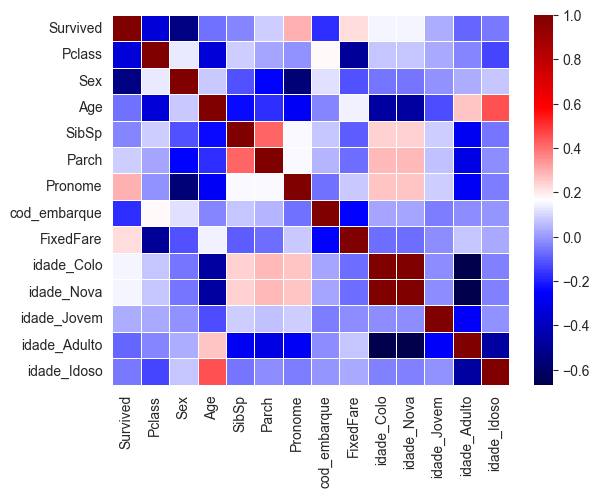

In [305]:
sns.heatmap(df_treino.corr(), linewidths=0.5, cmap='seismic')

## Etapa III - Modelagem

### Separacao e Holdout

In [306]:
test_size = 0.2
seed = 1

# Separacao em conjunto de teste e treino
array = df_treino.values
X = array[:,1:12]
y = array[:,0]
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=test_size,
    random_state=seed,
    shuffle=True,
    stratify=y
)

scoring= 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

In [307]:
np.random.seed(seed)

models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



LR: 0.814652 (0.045042)
KNN: 0.748513 (0.024643)
CART: 0.797770 (0.046090)
NB: 0.749922 (0.034276)
SVM: 0.696694 (0.034426)
Bagging: 0.810466 (0.045363)
RF: 0.801956 (0.046886)
ET: 0.787911 (0.049796)
Ada: 0.813243 (0.045170)
GB: 0.804812 (0.044884)
Voting: 0.814710 (0.049658)


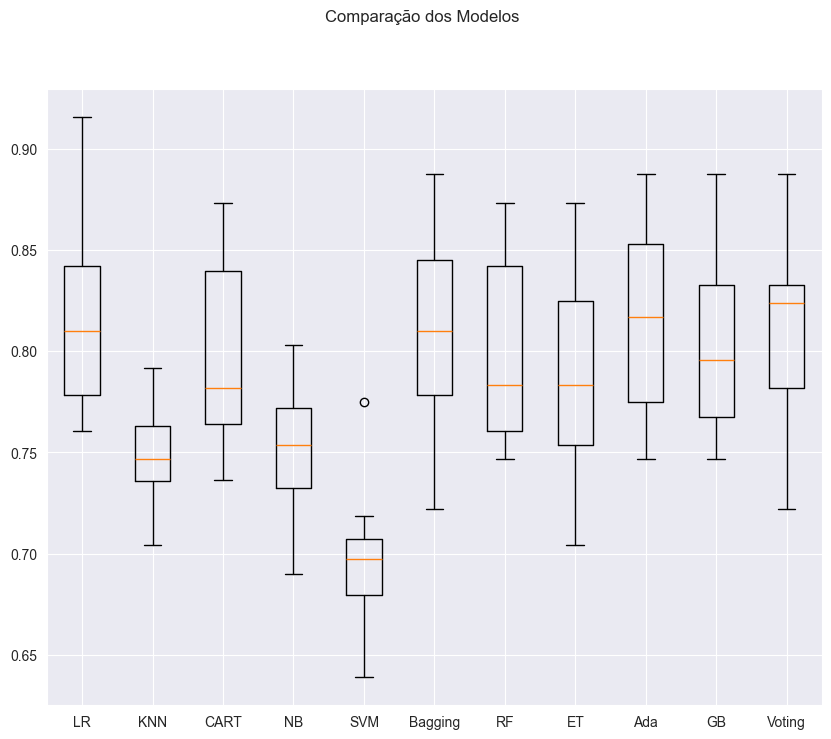

In [311]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(10,8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Parecem interessantes até o momento o algoritmo ADA e o algoritmo LR (Regressão Logística).

## Otimizacao de Hiperparametros

In [314]:
np.random.seed(seed)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: LR-orig - Melhor: 0.811790 usando {'LR__C': 1, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.820191 usando {'LR__C': 0.1, 'LR__solver': 'liblinear'}
Modelo: LR-norm - Melhor: 0.818783 usando {'LR__C': 1, 'LR__solver': 'saga'}
Modelo: KNN-orig - Melhor: 0.750074 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Modelo: KNN-padr - Melhor: 0.797794 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Modelo: KNN-norm - Melhor: 0.799202 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Modelo: CART-orig - Melhor: 0.807633 usando {'CART__max_depth': 50, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 2}
Modelo: CART-padr - Melhor: 0.809081 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 2}
Modelo: CART-norm - Melhor: 0.809042 usando {'CART__max_depth': 40, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 2}
Modelo: NB-orig - Melhor: 0.755580 usando {'NB__var_smoothing': 1e-05}
Modelo: NB-padr 

Com base nos dados acima é possível inferir que o melhor algoritmo foi o de Random Forest, com pouca diferença na precisão com dados normalizados, padronizados ou sem interferência. O método vencedor foi o `Modelo: RF-padr - Melhor: 0.825874 usando {'RF__max_depth': 30, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}`

## Finalização do modelo

In [321]:
np.random.seed(seed)

# Preparação do modelo
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = RandomForestClassifier(n_estimators=10,
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=30,
                               min_samples_leaf=2,
                               )
model.fit(rescaledX, y_train)

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))



0.7988826815642458


In [324]:
np.random.seed(seed)

model = RandomForestClassifier(n_estimators=10,
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=30,
                               min_samples_leaf=2,
                               )

pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('RF', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7988826815642458


## Salvando os arquivos

In [333]:
# Salvando o modelo
model_filename = 'rf_titanic_challenge.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'std_scaler_diabetes.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
    
# Salvando o pipeline
pipeline_filename = 'rf_titanic_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)
    
# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=df_treino.columns[1:12])
y_test_df = pd.DataFrame(y_test, columns=[df_treino.columns[0]])
X_test_df.to_csv("../data/X_test_dataset_titanic.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_titanic.csv", index=False)